In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry
import plotly.io as pio


In [68]:


def data_wrangler(path):
    # Load dataset
    df = pd.read_csv(path)
    
    # Drop useless columns (update if needed)
    drop_cols = ["Unnamed: 0", "Accessibility"]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    # Drop null values and duplicates
    df = df.dropna().drop_duplicates().reset_index(drop=True)
    # get rid of error entry in PreviousSalary by filtering out salaries <= 1000
    df = df[df.PreviousSalary > 1000]
    # Standardize country names (title case)
    df["Country"] = df["Country"].str.title()
    
    # Optional: common country name aliases
    alias_map = {
    "Usa": "United States",
    "Uk": "United Kingdom",
    "South Korea": "Korea, Republic of",
    "Viet Nam": "Vietnam",
    "Iran, Islamic Republic Of...": "Iran",
    "Hong Kong (S.A.R.)": "Hong Kong",
    "The Former Yugoslav Republic Of Macedonia": "North Macedonia",
    "Venezuela, Bolivarian Republic Of...": "Venezuela",
    "Democratic Republic Of The Congo": "Congo, The Democratic Republic of the",
    "Kosovo": "Kosovo",  # Pycountry may not include Kosovo officially
    "Nomadic": None,      # Not a country
    "Congo, Republic Of The...": "Congo",
    "Republic Of Korea": "Korea, Republic of",
    "Swaziland": "Eswatini",
    "Libyan Arab Jamahiriya": "Libya",
    "Palestine": "Palestine",  # May remain None if pycountry cannot resolve
    "Cape Verde": "Cabo Verde",
    "Turkey": "TUR"
    }
    df["Country"] = df["Country"].apply(lambda x: alias_map.get(x, x))
    
    # Safe ISO-3 mapping
    def safe_iso3(name):
        try:
            return pycountry.countries.lookup(name).alpha_3
        except LookupError:
            return None
    
    df["Country_ISO3"] = df["Country"].apply(safe_iso3)
    
    return df

    

In [69]:
path = "dataset/stackoverflow_full.csv"
df = data_wrangler(path)
df.head()

,Age,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed,Country_ISO3
0,<35,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0,SWE
1,<35,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1,ESP
2,<35,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0,DEU
3,<35,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0,CAN
4,>35,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0,SGP


In [70]:
df.columns

Index(['Age', 'EdLevel', 'Employment', 'Gender', 'MentalHealth', 'MainBranch',
       'YearsCode', 'YearsCodePro', 'Country', 'PreviousSalary',
       'HaveWorkedWith', 'ComputerSkills', 'Employed', 'Country_ISO3'],
      dtype='object')

## Age 

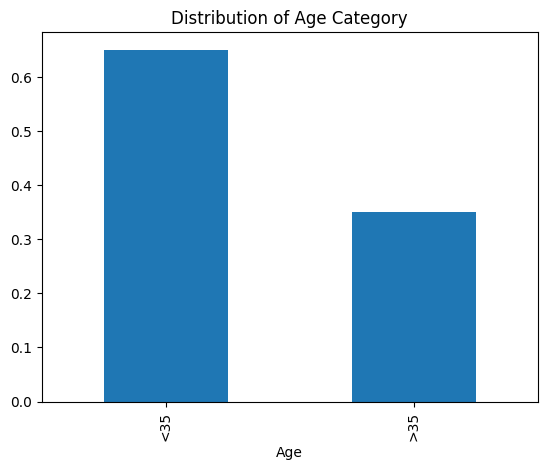

In [71]:
df.Age.value_counts(normalize=True).round(2).plot(kind='bar')
plt.title("Distribution of Age Category")
plt.show()

More than 65% of the survey participants are aged above 35 years, indicating that the dataset is predominantly composed of mid-career and senior individuals rather than early-career respondents.

In [72]:
# Distribution of Employment status by Age
df.groupby("Age")["Employed"].value_counts(normalize=True).round(2).unstack(fill_value=0)


Employed,0,1
Age,,
<35,0.45,0.55
>35,0.48,0.52


Employment rates are relatively similar across age groups, with a modest advantage for participants under 35. This suggests that age alone may not be a strong determinant of employment status in the dataset.

## Education Level

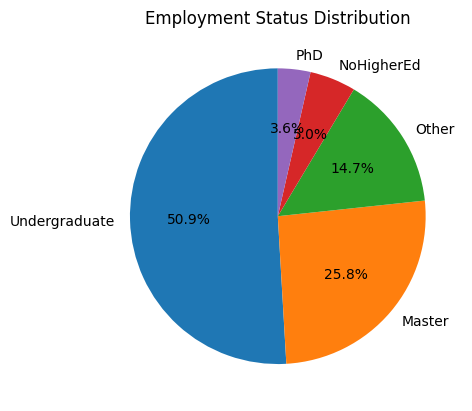

In [73]:
edlevel_dist = round(df.EdLevel.value_counts(normalize=True) *100,2).plot.pie(
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Employment Status Distribution")
plt.ylabel("") 
plt.show()

This distribution indicates that the dataset is heavily concentrated around undergraduate and master’s degree holders, with doctoral-level education being relatively rare among respondents.

## Country

In [74]:
country_counts = df.Country_ISO3.value_counts().reset_index()
country_counts.columns = ["Country","Count"]

# Use a renderer compatible with classic Jupyter notebooks
pio.renderers.default = "notebook_connected"
# Plot the distribution of participants 
fig = px.choropleth(
    country_counts,
    locations="Country",
    locationmode="ISO-3",
    color="Count",
    title="Distribution of Survey Participants by Country",
    color_continuous_scale="Reds"
)

fig.show()

In [75]:
#Top 10 Countries
top_10_df = round(df.Country.value_counts(normalize=True,ascending=False).head(10)*100,2).reset_index()
top_10_df

,Country,proportion
0,United States Of America,20.09
1,Germany,7.39
2,India,7.28
3,United Kingdom Of Great Britain And Northern I...,6.41
4,Canada,3.81
5,France,3.62
6,Brazil,3.58
7,Poland,2.63
8,Netherlands,2.41
9,Spain,2.33


The survey is heavily dominated by participants from a few countries.
The **United States** alone accounts for 20.0% of respondents.
Other top countries include **Germany** (7.35%), **India** (7.29%), and the **United Kingdom** (6.38%).
The remaining countries in the top 10 each contribute between 2.3% and 3.8% of respondents.

## Employment

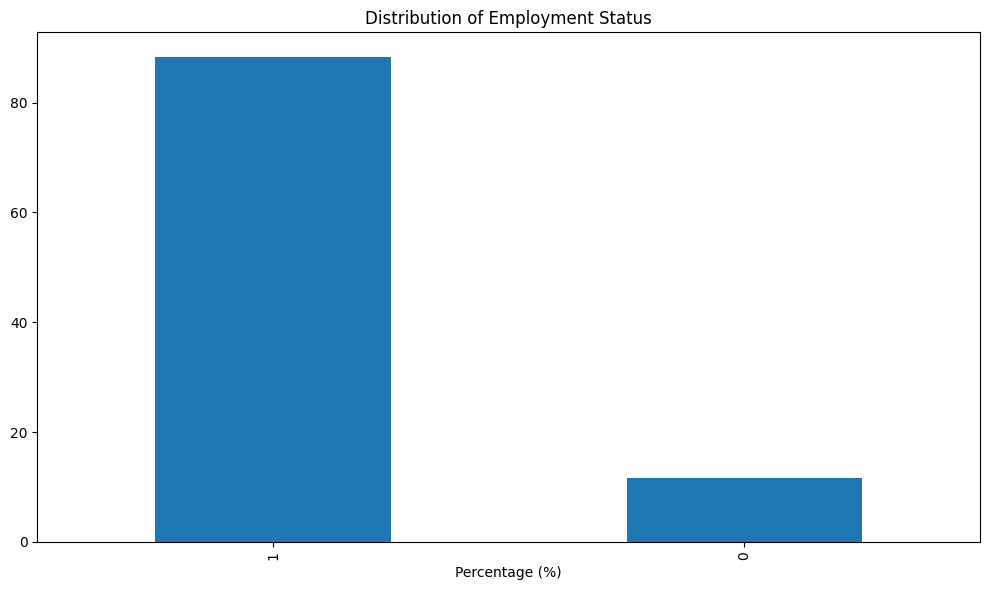

In [76]:
# Visualization of Employment distribution
employment_dist = df.Employment.value_counts(normalize=True).round(3) * 100
employment_dist.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution of Employment Status")
plt.xlabel("Percentage (%)")
plt.tight_layout()
plt.show()


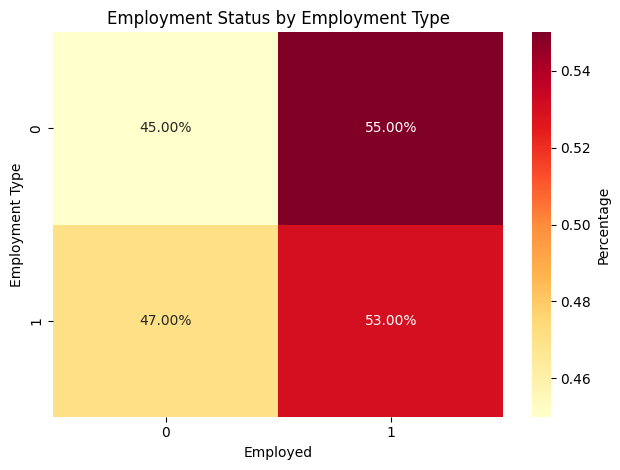

In [77]:
# Heatmap: Employment vs Employed relationship
employment_employed = df.groupby("Employment")["Employed"].value_counts(normalize=True).round(2).unstack(fill_value=0)
sns.heatmap(employment_employed, annot=True, fmt='.2%', cmap='YlOrRd', cbar_kws={'label': 'Percentage'})
plt.title("Employment Status by Employment Type")
plt.ylabel("Employment Type")
plt.xlabel("Employed")
plt.tight_layout()
plt.show()


The employment type distribution shows clear patterns. The majority of respondents fall into specific employment categories, with notable variation in employment status across different employment types. Some employment categories show higher employment rates, while others exhibit more variability, suggesting that employment type is a meaningful factor in predicting employment status.


## Year of Coding

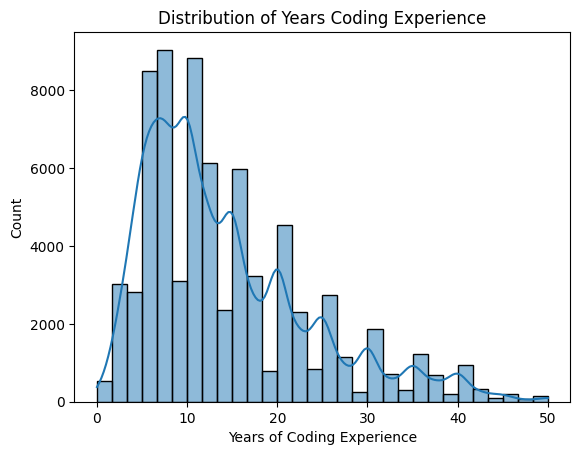

In [78]:
# Distribution of years coding using a histogram
sns.histplot(data=df, x="YearsCode", bins=30, kde=True)
plt.title("Distribution of Years Coding Experience")
plt.xlabel("Years of Coding Experience")
plt.show()



In [79]:
# Summary statistics for Years of Coding Experience
df.YearsCode.describe()


count    72913.000000
mean        14.239971
std          9.405137
min          0.000000
25%          7.000000
50%         12.000000
75%         20.000000
max         50.000000
Name: YearsCode, dtype: float64

The distribution of years of coding experience reveals the experience level of survey respondents. The mean and median values provide insight into the typical experience level, while the standard deviation indicates the spread. This variable is important for understanding the career progression and expertise levels within the dataset, and may be a significant predictor of employment status and other outcomes.


Correlation between YearsCode and YearsCodePro: 0.90


Text(0, 0.5, 'Years of Professional Coding Experience')

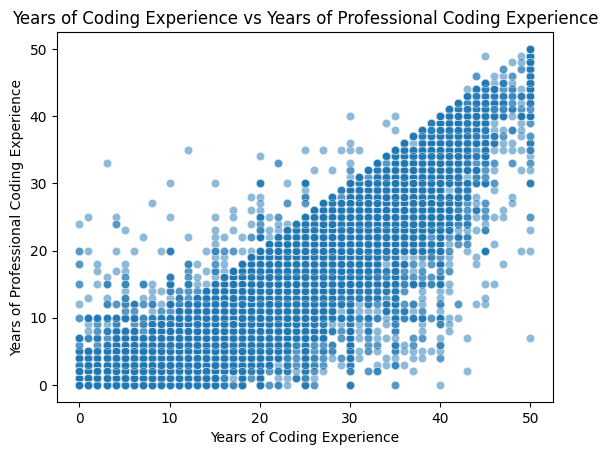

In [80]:
# correlation between YearsCode and YearsCodePro
correlation = df["YearsCode"].corr(df["YearsCodePro"])
print(f"Correlation between YearsCode and YearsCodePro: {correlation:.2f}")

# scatter plot: YearsCode vs years of professional coding experience
sns.scatterplot(data=df, x="YearsCode", y="YearsCodePro", alpha=0.5)
plt.title("Years of Coding Experience vs Years of Professional Coding Experience")
plt.xlabel("Years of Coding Experience")
plt.ylabel("Years of Professional Coding Experience")

both YearsCode and YearsCodePro show a strong positive correlation of 0.0.90, 
indicating that individuals with more overall coding experience tend to have more 
professional coding experience as well.
I will drop YearsCodePro from the feature set to avoid redundancy.

In [81]:
df = df.drop(columns=["YearsCodePro"])

In [82]:
df.head()

,Age,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed,Country_ISO3
0,<35,Master,1,Man,No,Dev,7,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0,SWE
1,<35,Undergraduate,1,Man,No,Dev,12,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1,ESP
2,<35,Master,1,Man,No,Dev,15,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0,DEU
3,<35,Undergraduate,1,Man,No,Dev,9,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0,CAN
4,>35,PhD,0,Man,No,NotDev,40,Singapore,160932.0,C++;Python,2,0,SGP


In [83]:
#transform HaveWorkedWith column by replacing ; with a comma , and get the length of each entry
df["HaveWorkedWith_Count"] = df["HaveWorkedWith"].str.replace(";", ",").apply(lambda x: len(x.split(",")) if pd.notnull(x) else 0)
# check if the new column matches ComputerSkills
(df.HaveWorkedWith_Count == df.ComputerSkills).all()

np.True_

In [84]:
df.head()

,Age,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed,Country_ISO3,HaveWorkedWith_Count
0,<35,Master,1,Man,No,Dev,7,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0,SWE,4
1,<35,Undergraduate,1,Man,No,Dev,12,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1,ESP,12
2,<35,Master,1,Man,No,Dev,15,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0,DEU,7
3,<35,Undergraduate,1,Man,No,Dev,9,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0,CAN,13
4,>35,PhD,0,Man,No,NotDev,40,Singapore,160932.0,C++;Python,2,0,SGP,2


In [85]:
# check for the most common technologies/tools worked with
common_lang =df["HaveWorkedWith"].str.split(";").explode().value_counts(normalize=True,ascending=False) *100


In [86]:
# Split HaveWorkedWith and replace low-frequency languages with "Other"
# Get frequency of each language
all_languages = df["HaveWorkedWith"].str.split(";").explode()
language_freq = all_languages.value_counts(normalize=True) * 100  # percentage
print(f"Total unique languages: {len(language_freq)}")
print(f"\nLanguages with >= 2% frequency:\n{language_freq[language_freq >= 2.0]}")

# Identify languages with frequency < 2%
low_freq_languages = set(language_freq[language_freq < 2.0].index)
print(f"\nNumber of low-frequency languages (< 2%): {len(low_freq_languages)}")

# Create function to replace low-frequency languages
def replace_low_freq_languages(languages_str, low_freq_set):
    if pd.notnull(languages_str):
        languages = languages_str.split(";")
        return ";".join([lang if lang not in low_freq_set else "Other" for lang in languages])
    return languages_str

# Apply the transformation
df["HaveWorkedWith_Grouped"] = df["HaveWorkedWith"].apply(lambda x: replace_low_freq_languages(x, low_freq_languages))

# Show sample
print("\nSample of original vs grouped:")
print(df[["HaveWorkedWith", "HaveWorkedWith_Grouped"]].head())


Total unique languages: 116

Languages with >= 2% frequency:
HaveWorkedWith
JavaScript              5.002914
Docker                  4.083876
HTML/CSS                4.075711
SQL                     3.890781
Git                     3.650229
AWS                     3.204437
Python                  3.161164
PostgreSQL              3.051961
MySQL                   2.984092
TypeScript              2.791814
Node.js                 2.641890
React.js                2.503294
Java                    2.296931
Bash/Shell              2.228960
C#                      2.205079
Microsoft SQL Server    2.040050
Name: proportion, dtype: float64

Number of low-frequency languages (< 2%): 100

Sample of original vs grouped:
                                      HaveWorkedWith  \
0                          C++;Python;Git;PostgreSQL   
1  Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...   
2             C;C++;Java;Perl;Ruby;Git;Ruby on Rails   
3  Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...   
4   

In [87]:
df.head()

,Age,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed,Country_ISO3,HaveWorkedWith_Count,HaveWorkedWith_Grouped
0,<35,Master,1,Man,No,Dev,7,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0,SWE,4,Other;Python;Git;PostgreSQL
1,<35,Undergraduate,1,Man,No,Dev,12,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1,ESP,12,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...
2,<35,Master,1,Man,No,Dev,15,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0,DEU,7,Other;Other;Java;Other;Other;Git;Other
3,<35,Undergraduate,1,Man,No,Dev,9,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0,CAN,13,Bash/Shell;HTML/CSS;JavaScript;Other;Other;SQL...
4,>35,PhD,0,Man,No,NotDev,40,Singapore,160932.0,C++;Python,2,0,SGP,2,Other;Python


In [88]:
# Create dummy variables from HaveWorkedWith_Grouped
# Split the grouped languages and create a temporary dataframe
languages_split = df["HaveWorkedWith_Grouped"].str.split(";").explode().reset_index()
languages_split.columns = ["index", "language"]

# Create dummy variables
dummy_languages = pd.get_dummies(languages_split["language"], prefix="Lang")

# Combine with index to aggregate by original row
dummy_languages["index"] = languages_split["index"].values

# Group by index and take max (since we want 1 if the language appears, 0 otherwise)
dummy_languages_final = dummy_languages.groupby("index").max()

# Add the dummy columns to the dataframe
df = pd.concat([df, dummy_languages_final], axis=1)
language_columns = [col for col in df.columns if col.startswith('Lang_')]
df[language_columns] = df[language_columns].astype(int)

print(f"Created {len(dummy_languages_final.columns)} dummy language columns")
print(f"\nDummy columns created:")
print(dummy_languages_final.columns.tolist())
print(f"\nDataframe shape: {df.shape}")
df.head()


Created 17 dummy language columns

Dummy columns created:
['Lang_AWS', 'Lang_Bash/Shell', 'Lang_C#', 'Lang_Docker', 'Lang_Git', 'Lang_HTML/CSS', 'Lang_Java', 'Lang_JavaScript', 'Lang_Microsoft SQL Server', 'Lang_MySQL', 'Lang_Node.js', 'Lang_Other', 'Lang_PostgreSQL', 'Lang_Python', 'Lang_React.js', 'Lang_SQL', 'Lang_TypeScript']

Dataframe shape: (72913, 32)


,Age,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed,Country_ISO3,HaveWorkedWith_Count,HaveWorkedWith_Grouped,Lang_AWS,Lang_Bash/Shell,Lang_C#,Lang_Docker,Lang_Git,Lang_HTML/CSS,Lang_Java,Lang_JavaScript,Lang_Microsoft SQL Server,Lang_MySQL,Lang_Node.js,Lang_Other,Lang_PostgreSQL,Lang_Python,Lang_React.js,Lang_SQL,Lang_TypeScript
0,<35,Master,1,Man,No,Dev,7,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0,SWE,4,Other;Python;Git;PostgreSQL,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
1,<35,Undergraduate,1,Man,No,Dev,12,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1,ESP,12,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,1,1,0,0,1,1,0,1,0,0,1,1,1,0,1,1,1
2,<35,Master,1,Man,No,Dev,15,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0,DEU,7,Other;Other;Java;Other;Other;Git;Other,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
3,<35,Undergraduate,1,Man,No,Dev,9,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0,CAN,13,Bash/Shell;HTML/CSS;JavaScript;Other;Other;SQL...,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0
4,>35,PhD,0,Man,No,NotDev,40,Singapore,160932.0,C++;Python,2,0,SGP,2,Other;Python,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [89]:
# drop the original HaveWorkedWith columns
df = df.drop(columns=["HaveWorkedWith", "HaveWorkedWith_Grouped"])


In [90]:
# show all the columns of the dataframe using the settings option

pd.set_option('display.max_columns', None)
df.head()

,Age,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,Country,PreviousSalary,ComputerSkills,Employed,Country_ISO3,HaveWorkedWith_Count,Lang_AWS,Lang_Bash/Shell,Lang_C#,Lang_Docker,Lang_Git,Lang_HTML/CSS,Lang_Java,Lang_JavaScript,Lang_Microsoft SQL Server,Lang_MySQL,Lang_Node.js,Lang_Other,Lang_PostgreSQL,Lang_Python,Lang_React.js,Lang_SQL,Lang_TypeScript
0,<35,Master,1,Man,No,Dev,7,Sweden,51552.0,4,0,SWE,4,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
1,<35,Undergraduate,1,Man,No,Dev,12,Spain,46482.0,12,1,ESP,12,1,1,0,0,1,1,0,1,0,0,1,1,1,0,1,1,1
2,<35,Master,1,Man,No,Dev,15,Germany,77290.0,7,0,DEU,7,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
3,<35,Undergraduate,1,Man,No,Dev,9,Canada,46135.0,13,0,CAN,13,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0
4,>35,PhD,0,Man,No,NotDev,40,Singapore,160932.0,2,0,SGP,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


## Salary

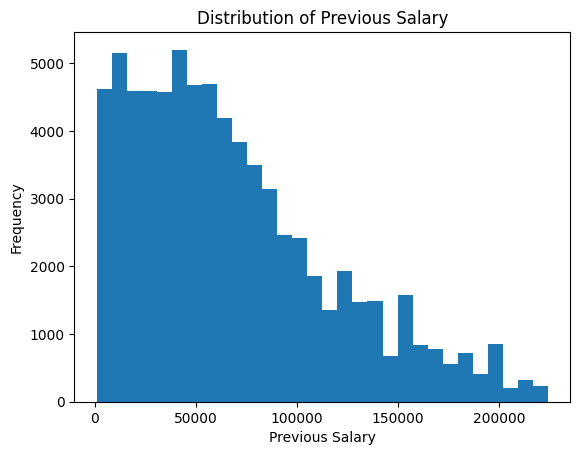

count     72913.000000
mean      68212.656879
std       49349.442204
min        1008.000000
25%       29688.000000
50%       58075.000000
75%       96000.000000
max      224000.000000
Name: PreviousSalary, dtype: float64

In [91]:
# distribution of PreviousSalary using a histogram


import matplotlib.pyplot as plt

plt.hist(df.PreviousSalary, bins=30)
plt.xlabel('Previous Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Previous Salary')
plt.show()

df.PreviousSalary.describe()

In [92]:
# correlation between PreviousSalary and employed
correlation_salary_employed = df["PreviousSalary"].corr(df["Employed"].astype(int))
print(f"Correlation between PreviousSalary and Employed: {correlation_salary_employed:.2f}")


Correlation between PreviousSalary and Employed: -0.00


**Previous Salary Analysis**

The salary distribution is **right-skewed** with Median ($58,075) < Mean ($68,213), indicating high earners pull the average upward. After filtering out erroneous entries ≤ $1,000, the dataset contains 72,913 respondents with salaries ranging from $1,008 to $224,000 (IQR: $29,688 - $96,000).

**Key Finding**: Previous salary shows **zero correlation (-0.00) with current employment status**, suggesting salary history alone is not predictive of employment. Other factors like skills, experience, and location matter more. The high standard deviation ($49,349) indicates substantial salary variation across job markets and experience levels, confirming the dataset is now clean for model building.


In [93]:
df.head()

,Age,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,Country,PreviousSalary,ComputerSkills,Employed,Country_ISO3,HaveWorkedWith_Count,Lang_AWS,Lang_Bash/Shell,Lang_C#,Lang_Docker,Lang_Git,Lang_HTML/CSS,Lang_Java,Lang_JavaScript,Lang_Microsoft SQL Server,Lang_MySQL,Lang_Node.js,Lang_Other,Lang_PostgreSQL,Lang_Python,Lang_React.js,Lang_SQL,Lang_TypeScript
0,<35,Master,1,Man,No,Dev,7,Sweden,51552.0,4,0,SWE,4,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
1,<35,Undergraduate,1,Man,No,Dev,12,Spain,46482.0,12,1,ESP,12,1,1,0,0,1,1,0,1,0,0,1,1,1,0,1,1,1
2,<35,Master,1,Man,No,Dev,15,Germany,77290.0,7,0,DEU,7,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
3,<35,Undergraduate,1,Man,No,Dev,9,Canada,46135.0,13,0,CAN,13,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0
4,>35,PhD,0,Man,No,NotDev,40,Singapore,160932.0,2,0,SGP,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


### PREPARE DATA FOR MACHINE LEARNING

In [94]:
# Prepare the final dataset for modeling
column_to_keep = ["EdLevel", "Age", "Employment", "PreviousSalary", "YearsCode", "ComputerSkills","Employed"]
for col in df.columns.tolist():
    if col.startswith("Lang_"):
        column_to_keep.append(col)

print(f"Columns to keep for modeling: {column_to_keep}")

Columns to keep for modeling: ['EdLevel', 'Age', 'Employment', 'PreviousSalary', 'YearsCode', 'ComputerSkills', 'Employed', 'Lang_AWS', 'Lang_Bash/Shell', 'Lang_C#', 'Lang_Docker', 'Lang_Git', 'Lang_HTML/CSS', 'Lang_Java', 'Lang_JavaScript', 'Lang_Microsoft SQL Server', 'Lang_MySQL', 'Lang_Node.js', 'Lang_Other', 'Lang_PostgreSQL', 'Lang_Python', 'Lang_React.js', 'Lang_SQL', 'Lang_TypeScript']


In [95]:
df.MainBranch.value_counts(normalize=True)

MainBranch
Dev       0.9176
NotDev    0.0824
Name: proportion, dtype: float64

Note: `MainBranch` is highly imbalanced (≈ 91.8% Dev vs 8.2% NotDev). This column offers little predictive signal for most models and should be dropped  before modeling.

In [96]:
for col in column_to_keep:
    print(col)

EdLevel
Age
Employment
PreviousSalary
YearsCode
ComputerSkills
Employed
Lang_AWS
Lang_Bash/Shell
Lang_C#
Lang_Docker
Lang_Git
Lang_HTML/CSS
Lang_Java
Lang_JavaScript
Lang_Microsoft SQL Server
Lang_MySQL
Lang_Node.js
Lang_Other
Lang_PostgreSQL
Lang_Python
Lang_React.js
Lang_SQL
Lang_TypeScript


In [97]:
model_df = df[column_to_keep]
model_df.head()

,EdLevel,Age,Employment,PreviousSalary,YearsCode,ComputerSkills,Employed,Lang_AWS,Lang_Bash/Shell,Lang_C#,Lang_Docker,Lang_Git,Lang_HTML/CSS,Lang_Java,Lang_JavaScript,Lang_Microsoft SQL Server,Lang_MySQL,Lang_Node.js,Lang_Other,Lang_PostgreSQL,Lang_Python,Lang_React.js,Lang_SQL,Lang_TypeScript
0,Master,<35,1,51552.0,7,4,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
1,Undergraduate,<35,1,46482.0,12,12,1,1,1,0,0,1,1,0,1,0,0,1,1,1,0,1,1,1
2,Master,<35,1,77290.0,15,7,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
3,Undergraduate,<35,1,46135.0,9,13,0,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0
4,PhD,>35,0,160932.0,40,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [98]:
model_df["Age (>35)"] = (model_df["Age"] == '>35').astype('int')
# drop the original Age column
model_df = model_df.drop(columns=["Age"])
model_df.head()

C:\Users\chake\AppData\Local\Temp\ipykernel_9516\48277085.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,EdLevel,Employment,PreviousSalary,YearsCode,ComputerSkills,Employed,Lang_AWS,Lang_Bash/Shell,Lang_C#,Lang_Docker,Lang_Git,Lang_HTML/CSS,Lang_Java,Lang_JavaScript,Lang_Microsoft SQL Server,Lang_MySQL,Lang_Node.js,Lang_Other,Lang_PostgreSQL,Lang_Python,Lang_React.js,Lang_SQL,Lang_TypeScript,Age (>35)
0,Master,1,51552.0,7,4,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0
1,Undergraduate,1,46482.0,12,12,1,1,1,0,0,1,1,0,1,0,0,1,1,1,0,1,1,1,0
2,Master,1,77290.0,15,7,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
3,Undergraduate,1,46135.0,9,13,0,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0,0
4,PhD,0,160932.0,40,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1


In [99]:
model_df.EdLevel.unique()

array(['Master', 'Undergraduate', 'PhD', 'Other', 'NoHigherEd'],
      dtype=object)

In [100]:
# Encode EdLevel as ordinal
edu_map = {
    "Other": 0,
    "NoHigherEd": 1,
    "Undergraduate": 2,
    "Master": 3,
    "PhD": 4
}

model_df["edlevel_encoded"] = model_df["EdLevel"].map(edu_map)
model_df = model_df.drop(columns=["EdLevel"])
model_df.head()



,Employment,PreviousSalary,YearsCode,ComputerSkills,Employed,Lang_AWS,Lang_Bash/Shell,Lang_C#,Lang_Docker,Lang_Git,Lang_HTML/CSS,Lang_Java,Lang_JavaScript,Lang_Microsoft SQL Server,Lang_MySQL,Lang_Node.js,Lang_Other,Lang_PostgreSQL,Lang_Python,Lang_React.js,Lang_SQL,Lang_TypeScript,Age (>35),edlevel_encoded
0,1,51552.0,7,4,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,3
1,1,46482.0,12,12,1,1,1,0,0,1,1,0,1,0,0,1,1,1,0,1,1,1,0,2
2,1,77290.0,15,7,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,3
3,1,46135.0,9,13,0,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0,0,2
4,0,160932.0,40,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,4


In [101]:
# Save the prepared dataset
model_df.to_csv("dataset/stackoverflow_prepared.csv", index=False)